In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

In [2]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

In [3]:
char2int_ki = {
    "T": 0,  # ki platform
    "M": 1,  # ki movable platform
    "D": 2,  # ki door
    "#": 3,  # ki ground
    "H": 4,  # ki hazard
    "*": 5,  # for ki background, different from vglc (from Anurag's email)
    "P": 6,  # for ki path (from Anurag's email)
}
int2char = {v:k for k, v in char2int_ki.items()}

## Density

In [22]:
json_fname = './kia_gmvae_20_10000.json'
num_components = int(json_fname.split('_')[2])
num_gens_per_comp = 10000 // num_components

In [23]:
chunks_int = open_json_as_nparray(json_fname)
begin, end = 0, num_gens_per_comp
chunks_by_comp = []
for i in range(num_components):
    chunks_by_comp.append(chunks_int[begin:end])
    begin, end = begin + num_gens_per_comp, end + num_gens_per_comp

In [24]:
def get_densities(chunks):
    unique_indices = np.unique(chunks)
    densities = {i:[] for i in unique_indices}
    for idx, chunk in enumerate(chunks):
        for i in unique_indices:
            chunk_mod = chunk == i
            densities[i].append(np.count_nonzero(chunk_mod))
    return [np.mean(v) for k, v in densities.items()]

In [25]:
densities_by_comp = [get_densities(chunks) for chunks in chunks_by_comp]
len(densities_by_comp)

20

In [26]:
df = pd.DataFrame(densities_by_comp)
df = df.fillna(0)
df /= df.max()
df.columns = [int2char[i] for i in np.unique(chunks_int)]
df = df.iloc[:,:-1]
df.head()

,T,M,D,#,H,*
0,0.446824,0.016148,1.000000,0.001570,0.946769,0.095753
1,0.356757,0.013598,0.026265,0.997536,0.006376,0.549042
2,0.175274,0.794731,0.003084,0.373825,0.012431,0.758161
3,0.355857,0.142979,0.006387,0.242694,0.010205,0.903081
4,1.000000,0.028246,0.012940,0.023163,0.000401,1.000000


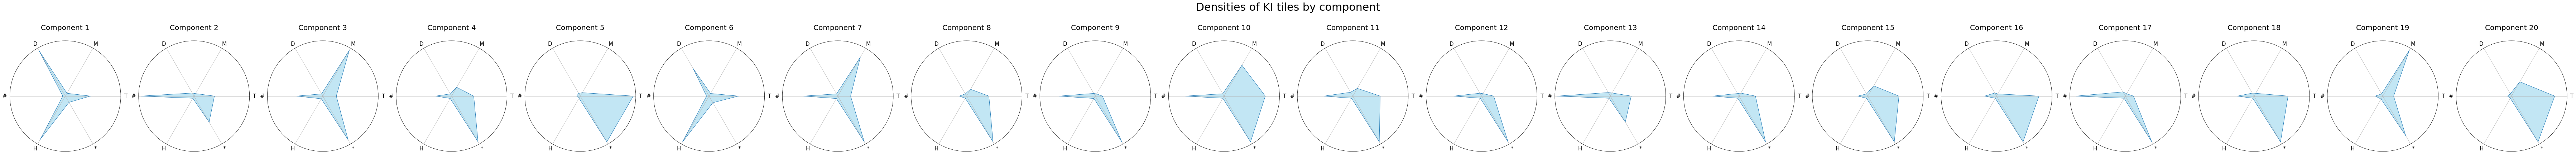

In [27]:
categories = list(df)

fig, axs = plt.subplots(nrows=1, ncols=num_components, figsize=(num_components * 5, 5),
                           subplot_kw=dict(polar=True))
axs = axs.flatten()

for i in range(num_components):
    
    ax = axs[i]
    
    values = df.iloc[i].tolist()
    values += values[:1] # repeat the first value to close the circular graph
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=15)
    ax.set_yticks([])
    ax.set_rlabel_position(30)

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'skyblue', alpha=0.5)
    
    ax.set_title(f'Component {i+1}', y=1.08, fontsize=20)

plt.suptitle('Densities of KI tiles by component', y=1.20, fontsize=30)
plt.tight_layout()
plt.show()

## Plotting generations from each component

In [28]:
import sys
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

In [29]:
def get_images(chunks_int):
    images = []
    for chunk in chunks_int:
        images.append(vglc_with_path_encodings.array_to_image([chunk], game='kia')[0])
    return images

In [ ]:
num_cols = 12
fig, axs = plt.subplots(num_components, num_cols, figsize=(2 * num_cols, 2 * num_components))
for comp_idx, chunks in enumerate(chunks_by_comp):
    imgs = get_images(chunks[:num_cols])
    for img_idx, img in enumerate(imgs):
        if img_idx == 1:
            ax.set_ylabel(f'Component {comp_idx + 1}')
        ax = axs[comp_idx][img_idx]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
plt.savefig(f'KIA generations per component (GM-VAE {num_components}).png', dpi=250)